In [3]:
!pip install seaborn


In [4]:
!pip install xgboost


  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Vehicle_ID                    10000 non-null  object 
 1   Mileage_km                    10000 non-null  int64  
 2   Fuel_Consumption_L_per_100km  10000 non-null  float64
 3   Engine_Hours                  10000 non-null  int64  
 4   Number_of_Trips               10000 non-null  int64  
 5   Engine_Temperature_C          10000 non-null  int64  
 6   Tire_Pressure_PSI             10000 non-null  float64
 7   Battery_Voltage_V             10000 non-null  float64
 8   Oil_Level_L                   10000 non-null  float64
 9   Vibration_Units               10000 non-null  float64
 10  Noise_Level_dB                10000 non-null  int64  
 11  Breakdown_Incidents           10000 non-null  int64  
 12  Part_Replacements             10000 non-null

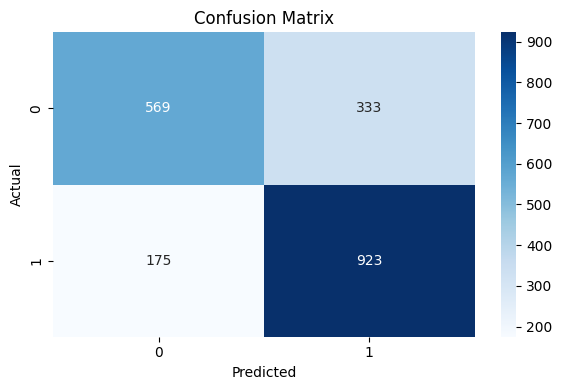

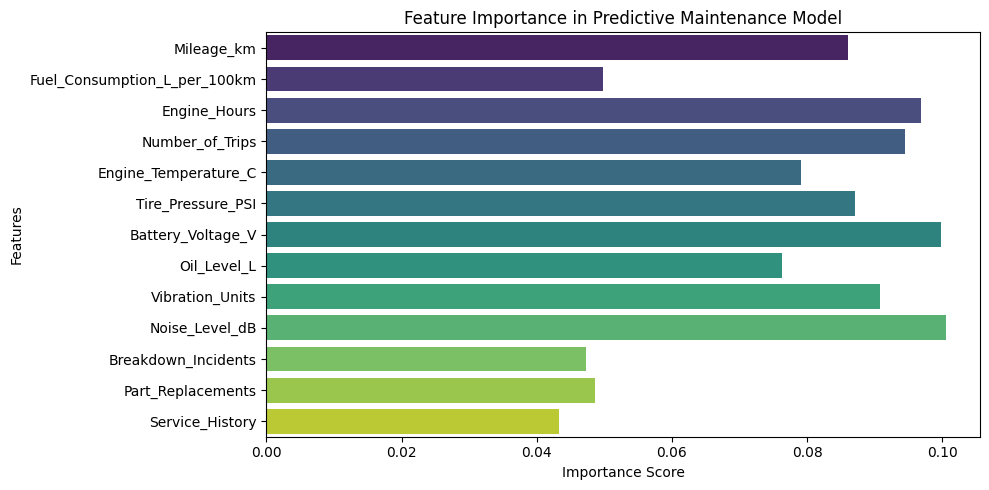

Model training complete with optimized hyperparameters! Ready for real-time predictions!

Enter Vehicle Details for Prediction:


Mileage (km):  120000
Fuel Consumption (L/100km):  12
Engine Hours:  12000
Number of Trips:  12345
Engine Temperature (°C):  123
Tire Pressure (PSI):  45
Battery Voltage (V):  14
Oil Level (L):  1
Vibration Units:  3
Noise Level (dB):  111
Breakdown Incidents:  4
Part Replacements:  4
Service History:  1



Predicted Maintenance Requirement: Yes


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
try:
    data = pd.read_csv("balanced_fleet_maintenance_schedule_2.csv")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

# Display basic info about the dataset
print("Dataset Summary:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

# Handling missing values (if any)
data = data.fillna(data.select_dtypes(include=['number']).median())

# Check if target column exists
if 'MaintenanceRequired' not in data.columns:
    print("Error: 'MaintenanceRequired' column not found in dataset.")
    exit()

# Remove Vehicle_ID before one-hot encoding as it shouldn't be used as a feature
if 'Vehicle_ID' in data.columns:
    data = data.drop(columns=['Vehicle_ID'])

# Encode categorical variables if needed
data = pd.get_dummies(data, drop_first=True)

# Define features (X) and target variable (y)
X = data.drop(columns=['MaintenanceRequired'])
y = data['MaintenanceRequired']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid (simplified for faster testing)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the model for CPU
xgb = XGBClassifier(
    tree_method='hist',  
    eval_metric='logloss',
    early_stopping_rounds=10
)

# Perform Randomized Search with reduced iterations and folds for testing
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=5,  # Reduced from 20 for testing
    cv=2,      # Reduced from 3 for testing
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=1
)

try:
    # Fit the model with best parameters
    random_search.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
    
    # Train final model with best parameters
    best_xgb = XGBClassifier(
        **random_search.best_params_,
        tree_method='hist',
        eval_metric='logloss'
    )
    best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
    
    # Make predictions
    y_pred = best_xgb.predict(X_test_scaled)

    # Model Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Feature Importance Plot
    feature_importance = best_xgb.feature_importances_
    features = X.columns

    plt.figure(figsize=(10,5))
    sns.barplot(x=feature_importance, y=features, hue=features, palette='viridis', dodge=False, legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance in Predictive Maintenance Model')
    plt.tight_layout()
    plt.show()

    print("Model training complete with optimized hyperparameters! Ready for real-time predictions!")

    # Function to get user input
    def get_user_input():
        print("\nEnter Vehicle Details for Prediction:")
        vehicle_data = {
            "Mileage_km": int(input("Mileage (km): ")),
            "Fuel_Consumption_L_per_100km": float(input("Fuel Consumption (L/100km): ")),
            "Engine_Hours": int(input("Engine Hours: ")),
            "Number_of_Trips": int(input("Number of Trips: ")),
            "Engine_Temperature_C": int(input("Engine Temperature (°C): ")),
            "Tire_Pressure_PSI": float(input("Tire Pressure (PSI): ")),
            "Battery_Voltage_V": float(input("Battery Voltage (V): ")),
            "Oil_Level_L": float(input("Oil Level (L): ")),
            "Vibration_Units": float(input("Vibration Units: ")),
            "Noise_Level_dB": int(input("Noise Level (dB): ")),
            "Breakdown_Incidents": int(input("Breakdown Incidents: ")),
            "Part_Replacements": int(input("Part Replacements: ")),
            "Service_History": int(input("Service History: ")),
        }
        return pd.DataFrame([vehicle_data])

    # Get user input and preprocess
    try:
        user_df = get_user_input()
        
        # Ensure the input has all the expected columns
        expected_features = X.columns
        for feature in expected_features:
            if feature not in user_df.columns:
                user_df[feature] = 0  # Add missing features with default value
        
        # Reorder columns to match training data
        user_df = user_df[expected_features]
        
        # Normalize input
        user_scaled = scaler.transform(user_df)  

        # Predict maintenance requirement
        prediction = best_xgb.predict(user_scaled)
        print("\nPredicted Maintenance Requirement:", "Yes" if prediction[0] == 1 else "No")
    except Exception as e:
        print(f"Error during prediction: {e}")

except Exception as e:
    print(f"Error during model training: {e}")


In [6]:
import pickle
with open('fleet_maintenance_prediction_model_cpu','wb') as f:
    pickle.dump(best_xgb,f)

In [7]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))